In [3]:
import wfdb
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch

# --- PARAMETRI ---
RECORD_PATH = "C:\\Users\\Fefo\\Desktop\\TMR\\mit-bih-arrhythmia-database-1.0.0"
# Trova automaticamente tutti i record disponibili
RECORDS = sorted(list(set(f.split('.')[0] for f in os.listdir(RECORD_PATH) if f.endswith('.dat'))))
WINDOW_SIZE = 1080
TARGET_CLASSES = {'N': 'Normale', 'A': 'AFIB', 'V': 'PVC', 'F': 'Altro'}
NUM_CLASSES = len(TARGET_CLASSES)

# --- ESTRAZIONE BATTITI ---
def extract_labeled_beats(record_list):
    segments, labels = [], []
    for rec in record_list:
        try:
            record = wfdb.rdrecord(f'{RECORD_PATH}/{rec}')
            ann = wfdb.rdann(f'{RECORD_PATH}/{rec}', 'atr')
            signal = record.p_signal[:, 0]
            for i, sym in enumerate(ann.symbol):
                if sym in TARGET_CLASSES:
                    idx = ann.sample[i]
                    if idx - WINDOW_SIZE//2 >= 0 and idx + WINDOW_SIZE//2 <= len(signal):
                        segment = signal[idx - WINDOW_SIZE//2: idx + WINDOW_SIZE//2]
                        segments.append(segment)
                        labels.append(TARGET_CLASSES[sym])
        except Exception as e:
            print(f"Errore nel record {rec}: {e}")
    return np.array(segments), np.array(labels)

# --- ESTRAZIONE E NORMALIZZAZIONE ---
X, y = extract_labeled_beats(RECORDS)

if X.size == 0:
    raise ValueError("⚠️ Nessun segmento è stato estratto. Controlla i file RECORDS o la cartella RECORD_PATH.")
else:
    X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
    X = X[..., np.newaxis]  # shape: (N, WINDOW_SIZE, 1)

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
    )

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


Ep 1 | Train acc: 0.4181 | Val acc: 0.5120
Ep 2 | Train acc: 0.4164 | Val acc: 0.3878
Ep 3 | Train acc: 0.4061 | Val acc: 0.3317
Ep 4 | Train acc: 0.4708 | Val acc: 0.6019
Ep 5 | Train acc: 0.4804 | Val acc: 0.4968
Ep 6 | Train acc: 0.5121 | Val acc: 0.5865
Ep 7 | Train acc: 0.5141 | Val acc: 0.5518
Ep 8 | Train acc: 0.6065 | Val acc: 0.6655
Ep 9 | Train acc: 0.6323 | Val acc: 0.5402
Ep 10 | Train acc: 0.7012 | Val acc: 0.7986
Ep 11 | Train acc: 0.7340 | Val acc: 0.8030
Ep 12 | Train acc: 0.7150 | Val acc: 0.7420
Ep 13 | Train acc: 0.7708 | Val acc: 0.7814
Ep 14 | Train acc: 0.7709 | Val acc: 0.8127
Ep 15 | Train acc: 0.7381 | Val acc: 0.7810
Ep 16 | Train acc: 0.7876 | Val acc: 0.7804
Ep 17 | Train acc: 0.7821 | Val acc: 0.7570
Ep 18 | Train acc: 0.7871 | Val acc: 0.8426
Ep 19 | Train acc: 0.8208 | Val acc: 0.8481
Ep 20 | Train acc: 0.7969 | Val acc: 0.8406
Ep 21 | Train acc: 0.8185 | Val acc: 0.8220
Ep 22 | Train acc: 0.8263 | Val acc: 0.8024
Ep 23 | Train acc: 0.8199 | Val acc: 0.80

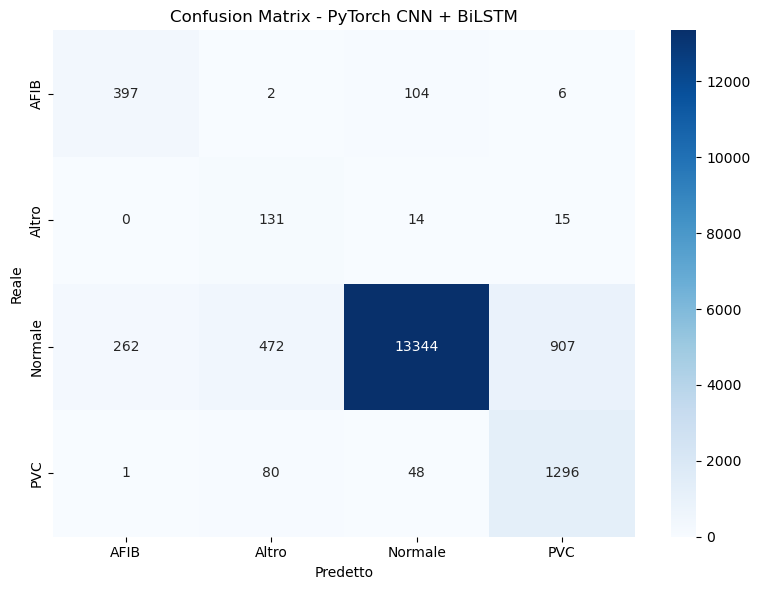


REPORT DI CLASSIFICAZIONE:

              precision    recall  f1-score   support

        AFIB      0.602     0.780     0.679       509
       Altro      0.191     0.819     0.310       160
     Normale      0.988     0.890     0.937     14985
         PVC      0.583     0.909     0.710      1425

    accuracy                          0.888     17079
   macro avg      0.591     0.850     0.659     17079
weighted avg      0.935     0.888     0.904     17079



In [4]:

# --- DATASET ---
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# --- MODELLO CNN + BiLSTM ---
class CNNBiLSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.bilstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)  # (B, 1, 1080) → (B, 1080, 1) → (B, 1, 1080)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.transpose(1, 2)  # (B, C, T) → (B, T, C) per LSTM
        x, _ = self.bilstm(x)
        x = x[:, -1, :]  # ultima uscita
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBiLSTM(input_size=WINDOW_SIZE, num_classes=NUM_CLASSES).to(device)

# --- TRAINING ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * y_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    val_loss, val_correct, val_total = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * y_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_acc = val_correct / val_total
    print(f"Ep {epoch+1} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter > 5:
            print("Early stopping")
            break

# --- VALUTAZIONE ---
model.load_state_dict(best_model)
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(y_batch.numpy())

# --- CONFUSION MATRIX ---
cm = confusion_matrix(all_true, all_preds)
labels = encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix - PyTorch CNN + BiLSTM')
plt.tight_layout()
plt.show()

# --- CLASSIFICATION REPORT ---
print("\nREPORT DI CLASSIFICAZIONE:\n")
print(classification_report(all_true, all_preds, target_names=labels, digits=3))
